# Evaluation: BIDMC

In [1]:
import gzip
import random
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
plt.style.use('ggplot')

2023-05-31 10:45:40.431491: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-31 10:45:40.478424: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 10:45:41.144322: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
with gzip.open(f'../../DataWarehouse/bidmc_RRpo/40_230522_resamp_sliced125_filt_patient_bidmc.pickle.gzip', 'rb') as f:
    dataset = pickle.load(f)
print(len(dataset), len(dataset[0][0]))

21050 1800


In [3]:
random.seed(42)
random.shuffle(dataset)

In [4]:
pleths = []
resps = []
for ppg, rr in dataset:
    pleths.append(ppg.astype(np.float64))
    resps.append(rr)

pleths = np.asarray(pleths)
resps = np.asarray(resps)
print(pleths.shape, resps.shape)

(21050, 1800) (21050,)


In [5]:
scaler = MinMaxScaler()
scaled_pleths = np.asarray([scaler.fit_transform(pleth.reshape(-1,1)) for pleth in pleths])
print(scaled_pleths.shape, type(scaled_pleths[0][0][0]))
print(scaled_pleths.shape, resps.shape)

(21050, 1800, 1) <class 'numpy.float64'>
(21050, 1800, 1) (21050,)


In [6]:
eval_dataset = tf.data.Dataset.from_tensor_slices((scaled_pleths, resps)).batch(256)

2023-05-31 10:45:51.390410: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14360 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:73:00.0, compute capability: 7.5


In [7]:
model = tf.keras.models.load_model('../models/230531-RespDNN-3times-4dil-SGD')

In [8]:
model.evaluate(eval_dataset)

2023-05-31 10:46:02.764069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [21050]
	 [[{{node Placeholder/_1}}]]
2023-05-31 10:46:03.898741: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


83/83 [==============================] - 8s 65ms/step - loss: 3.6817 - mean_absolute_error: 3.6817


[3.6817150115966797, 3.6817150115966797]

In [9]:
pred_y = model.predict(eval_dataset)
print(pred_y.shape, resps.shape)

83/83 [==============================] - 5s 57ms/step
(21050, 1) (21050,)


In [10]:
abs_err = abs(resps.reshape(-1,1) - pred_y)
print(f'{np.mean(abs_err)} ± {np.std(abs_err)}')

3.6817154682367828 ± 2.8709991457354613


위와 같은 부분은 한계점으로 작용할 수 있다.

검증을 진행하였을 때 서울성모병원 외과중환자실의 환경에 Bias 되었을 가능성을 배제할 수 없기 때문이다.

즉 서울성모병원 SICU의 환경을 조정하더라도 BIDMC의 환경을 조정할 수 없다.

In [23]:
pred_y

array([[17.192728],
       [24.422562],
       [14.320824],
       ...,
       [18.745573],
       [14.380933],
       [19.627756]], dtype=float32)

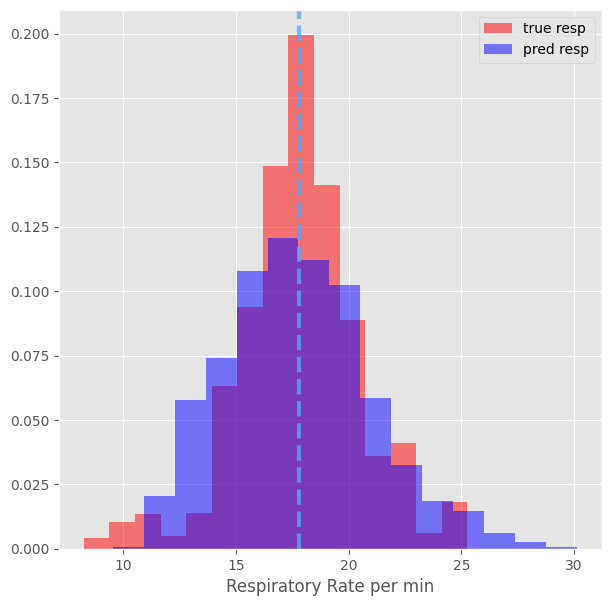

In [40]:
plt.figure(figsize=(7,7))
plt.hist(resps, bins=15, color='r', density=True, alpha=0.5, label='true resp')
plt.hist(pred_y, bins=15, color='b', density=True, alpha=0.5, label='pred resp')
plt.axvline(resps.mean(), color='magenta', linestyle='--', linewidth=3, alpha=.5)
plt.axvline(pred_y.mean(), color='cyan', linestyle='--', linewidth=3, alpha=.5)
plt.xlabel('Respiratory Rate per min')
plt.legend()
plt.show()

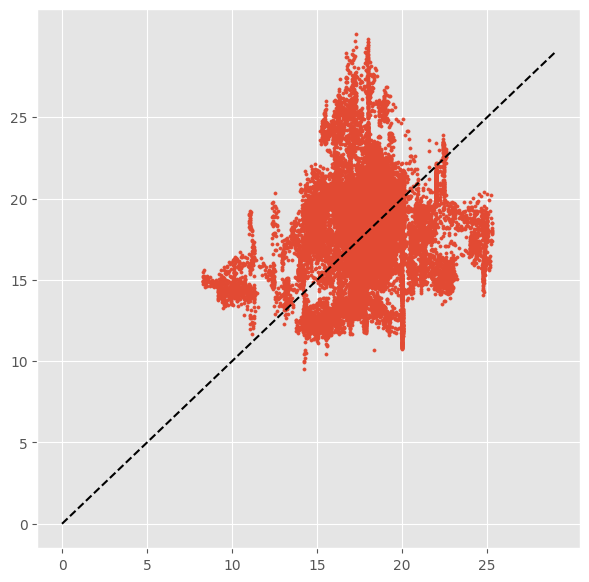

In [30]:
plt.figure(figsize=(7,7))
plt.scatter(resps, pred_y, s=5)
plt.plot(range(30), np.arange(0, 30), linestyle='--', color='black')
plt.xticks(np.arange(30, step=5), np.arange(30, step=5))
plt.yticks(np.arange(30, step=5), np.arange(30, step=5))
plt.show()

In [31]:
from scipy import stats

In [33]:
stats.bartlett(resps, pred_y.reshape(-1))

BartlettResult(statistic=862.1024774144232, pvalue=1.7001369936295072e-189)

BIDMC의 실제 호흡수와 예측 호흡수 사이의 등분산성 검정을 진행한 결과, pvalue가 유의수준 0.05보다 작으므로 대립가설을 채택하여 등분산성이 충족되지 않음을 확인하였다.

그러므로 이러한 경우에는 자유도를 수정한 강건한 t-test 인 `Welch t-test` 를 진행하여 두 집단의 평균이 같은지를 확인할 수 있다.

In [36]:
stats.ttest_ind(resps, pred_y.reshape(-1), equal_var=False)

Ttest_indResult(statistic=1.4641421773693013, pvalue=0.1431628717536274)

`Welch t-test`를 진행한 결과 pvalue 가 유의수준 0.05보다 크므로 귀무가설을 채택하여 두 집단의 평균이 같음, 곧 두 집단이 동일하다고 볼 수 있다.

이는 서울성모병원 SICU의 데이터를 이용해서 `ResNet`을 학습시킨 경우, BIDMC로 검증하였을 때의 성과가 `3.2602603242229304 ± 2.28855539984275` 이지만,

해당 결과가 유의미함을 간접적으로 설명하여준다.

위 Figure의 산점도 또한 분산된 부분이 존재하기는 하지만 양의 상관관계를 보이고 있는 것을 확인할 수 있다.

이를 통해 딥러닝 모델에 환자의 PPG를 이용하여 RR을 예측할 때의 유의미성을 확인할 수 있다.